# Simple forward

This tutorial was prepared by Alexandre Olender olender@usp.br

This tutorial focuses on solving the acoustic wave equation using Spyro's `AcousticWave` class. Our main objective is to familiarize you with the initial dictionary inputs, which (together with the **simple forward with Overthrust tutorial**) should be enough if you are an end-user only interested in the results of the forward propagation methods already implemented in our software. 

Please refer to our **meshing tutorial** if you need more control over meshing. For more examples of simple cases usually encountered in seismic imaging, please refer to the tutorial on using **pre-made useful examples**. If you are interested in developing code for Spyro, both the **altering time integration** and the **altering variational equation** tutorials suit you.

We currently have a **simple FWI** and **detailed synthetic FWI** tutorials for inversion-based tutorials.

If you are running this notebook in Google colab, please copy the following code into a code block before running the notebook:
```python
# For use in colab only:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

!pip install git+https://github.com/NDF-Poli-USP/spyro.git

In [1]:
# Code in this cell enables plotting in the notebook
%matplotlib inline

We begin by making Spyro available in our notebook. This is necessary for every python package.

In [2]:
import spyro
import numpy as np

Now, we begin to define our problem parameters. This can be done using a python dictionary.

In [3]:
dictionary = {}

The first dictionary deals with basic finite element options. Here, we define our cell type as simplexes (i.e., triangles or tetrahedrals), quadrilaterals, or hexahedrals (both refered to as Q in the code and quads in this notebook). We also define what our "variant" will be. For quads and hexas, we can use equispaced or lumped. Lumped quads (or hexahedra) are spectral elements with nodal and quadrature values on GLL nodes, resulting in diagonal mass matrices. Lumped triangles (or tetrahedra) use specific quadrature and collocation nodes to have diagonal mass matrices. Equispaced elements are more traditional finite elements.

In [4]:
dictionary["options"] = {
    "cell_type": "Q",  # simplexes such as triangles or tetrahedra (T) or quadrilaterals (Q)
    "variant": "lumped",  # lumped, equispaced or DG, default is lumped
    "degree": 4,  # p order
    "dimension": 2,  # dimension
}

Next, we define our parallelism type. Let us stick with automatic for now.

In [5]:
dictionary["parallelism"] = {
    "type": "automatic",  # options: automatic (same number of cores for evey processor) or spatial
}
dictionary["automatic_adjoint"] = True

We must also define our mesh parameters, such as size in every axis. Here, we also define whether there is a premade mesh file (we accept every mesh input Firedrake accepts) or if a certain automatically generated mesh type will be used. The firedrake_mesh option generates structured or semi-structured meshes using Firedrake's built-in meshing methods and works on both quads and simplexes. The SeismicMesh option allows us to generate automatic waveform-adapted unstructured meshes.

In [6]:
dictionary["mesh"] = {
    "Lz": 3.0,  # depth in km - always positive
    "Lx": 3.0,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "mesh_file": None,
    "mesh_type": "firedrake_mesh",
}

We also have to define our acquisition geometry for receivers and sources. Source-related properties such as type, location, frequency, and delay are among those available. Point receiver locations also have to be stated. Here, we can input locations as lists of coordinate tuples; however, when we have many sources or receivers arranged in an equal-spaced array, the spyro.create_transect method simplifies this input. 

In [7]:
dictionary["acquisition"] = {
    "source_type": "ricker",
    "source_locations": [(-1.1, 1.5)],
    "frequency": 5.0,
    "delay": 0.2,
    "delay_type": "time",
    "receiver_locations": spyro.create_transect((-1.9, 1.2), (-1.9, 1.8), 300),
}

Our time-domain inputs are also significant to both computational cost and accuracy. The bigger the timestep variable (dt) used here, the smaller the computational runtime of our simulation. However, a timestep too large leads to stability problems. For this example, we will set a value, but it is important to note that Spyro has a built-in tool to calculate the maximum stable timestep for a given problem. We can also define our output_frequency for visualization purposes; an output frequency of 100 means that for every 100 timesteps, Spyro will save the pressure across the domain visualization. The gradient sampling frequency will be set to 1 here and is only essential for inversion problems, which are not the focus of this tutorial.

In [8]:
dictionary["time_axis"] = {
    "initial_time": 0.0,  # Initial time for event
    "final_time": 1.0,  # Final time for event
    "dt": 0.001,  # timestep size
    "output_frequency": 100,  # how frequently to output solution to pvds
    "gradient_sampling_frequency": 1,  # how frequently to save solution to RAM
}

We can also define where we want everything to be saved. If left blank, most of these options will be replaced with default values.

In [9]:
dictionary["visualization"] = {
    "forward_output": True,
    "forward_output_filename": "results/forward_output.pvd",
    "fwi_velocity_model_output": False,
    "velocity_model_filename": None,
    "gradient_output": False,
    "gradient_filename": "results/Gradient.pvd",
    "adjoint_output": False,
    "adjoint_filename": None,
    "debug_output": False,
}

We can now create our acoustic wave object.

In [10]:
Wave_obj = spyro.AcousticWave(dictionary=dictionary)
print(Wave_obj.automatic_adjoint)

Parallelism type: automatic
Boundary layer type: None
True


/Users/ddolci/usp_postdoc/spyro/spyro/solvers/wave.py:91: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Since we are using a firedrake-generated mesh in this tutorial, we must set an element size for the mesh. Notice that in this case, we have also decided to use a periodic mesh; by default, this does not happen. This will create a periodic mesh in both directions. That means that when a wave propagates to a border, it will appear at the opposite border. For most user cases, we will have absorbing boundary conditions. The simple forward with overthrust tutorial will show how to use PML conditions.

In [11]:
Wave_obj.set_mesh(input_mesh_parameters={"edge_length": 0.02, "periodic": True})

Creating firedrake_mesh type mesh.


For our first tutorial, we will have a medium with a homogenous velocity similar to water velocity. For complex models that need to be loaded from a file, such as a 2D overthrust cut, see the **simple FWI with overthrust tutorial**. The set_initial_velocity_model shown below can also be used for conditionals, Firedrake functions, expressions, or files (segy or hdf5). This allows us to represent almost any heterogeneous velocity.

In [12]:
Wave_obj.set_initial_velocity_model(constant=1.5)

Before propagating our wave, it is helpful to see whether our experiment setup loaded correctly. We can plot our wave object.

File name model.png


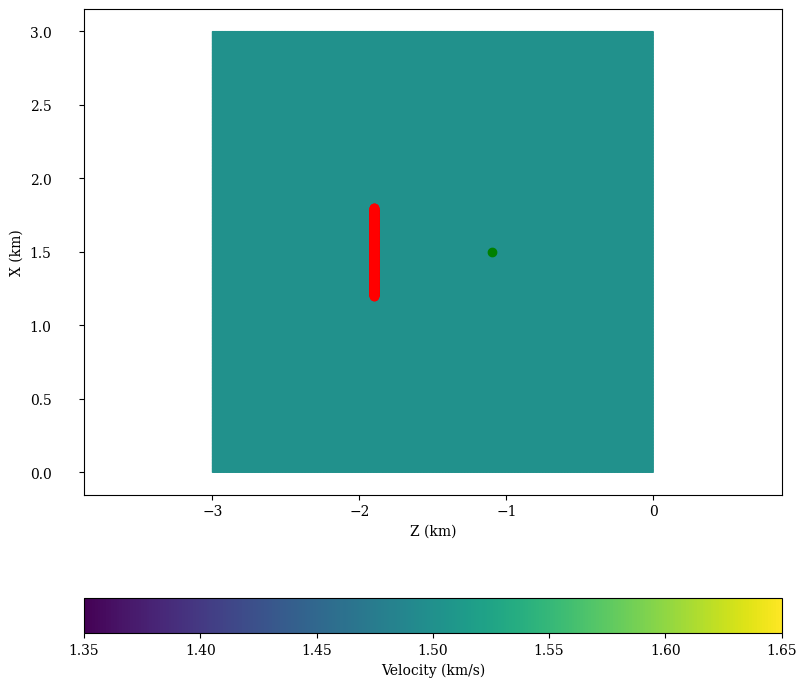

In [13]:
spyro.plots.plot_model(Wave_obj, filename="model.png", flip_axis=False, show=True)

All we have to do now is call our forward solve method.

In [14]:
Wave_obj.forward_solve()


Solving Forward Problem


/Users/ddolci/my_venv/lib/python3.13/site-packages/ufl/utils/sorting.py:94: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Saving Pressure in: results/forward_outputsn[0].pvd


/Users/ddolci/my_venv/lib/python3.13/site-packages/ufl/utils/sorting.py:94: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.0 seconds
Simulation time is:        0.1 seconds
Simulation time is:        0.2 seconds
Simulation time is:        0.3 seconds
Simulation time is:        0.4 seconds
Simulation time is:        0.5 seconds
Simulation time is:        0.6 seconds
Simulation time is:        0.7 seconds
Simulation time is:        0.8 seconds
Simulation time is:        0.9 seconds
Simulation time is:        1.0 seconds


We can look at the last pressure distribution. It is saved as a firedrake function inside our wave object.

In [15]:
last_pressure = Wave_obj.u_n

As with every Firedrake function, we can access a numpy array containing all nodal values (at every degree of freedom).

In [16]:
last_pressure_data = last_pressure.dat.data[:]

All Firedrake functions can be plotted using tools available inside Firedrake. We will use our own wrapper for this tutorial, but we recommend looking into Firedrake tutorials for more information.

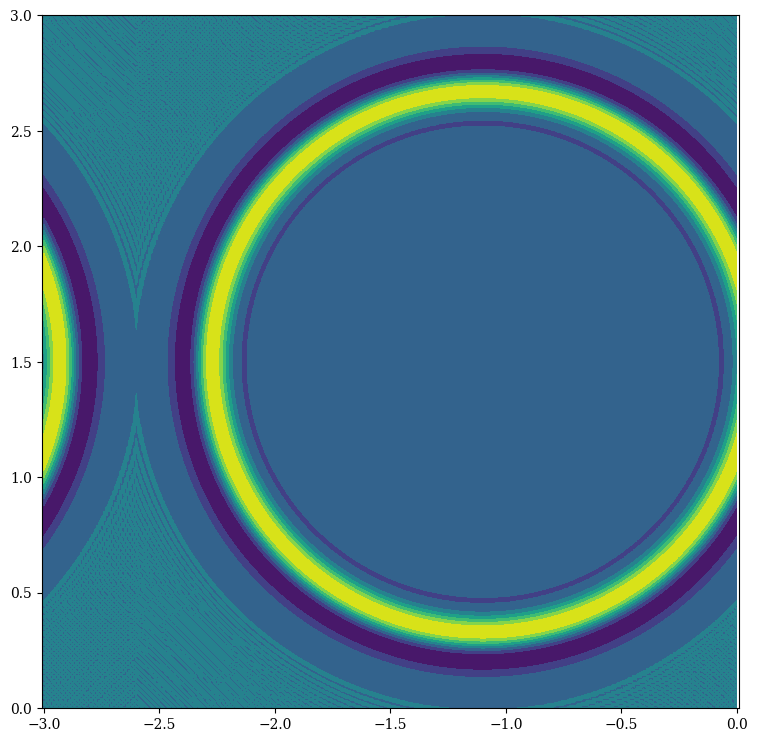

In [17]:
spyro.plots.plot_function(last_pressure)

In seismic imagining, the shot record is one of the most important outputs of the forward problem. It represents the pressure values recorded at every receiver and timestep. This is the data that we will use for inversion. Spyro saves shot records by default in the shots folder. We can also have a visual look at the shot record results here.

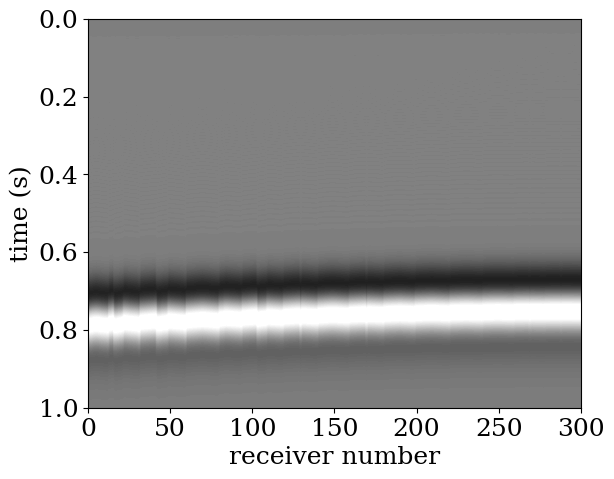

In [18]:
spyro.plots.plot_shots(Wave_obj, contour_lines=100, vmin=-np.max(last_pressure_data), vmax=np.max(last_pressure_data), show=True)
